In [1]:
!pip install -U efficientnet


In [2]:
!pip install efficientnet_3D

In [3]:
!pip install numpy -- upgrade


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


In [4]:
# import efficientnet.keras as efn
import efficientnet_3D.tfkeras as efn
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
import pandas as pd


2023-03-15 12:17:21.256243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 12:17:21.256265: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
local_zip = 'archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [7]:
validation_dir = os.path.join(base_dir, 'validation')


In [8]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

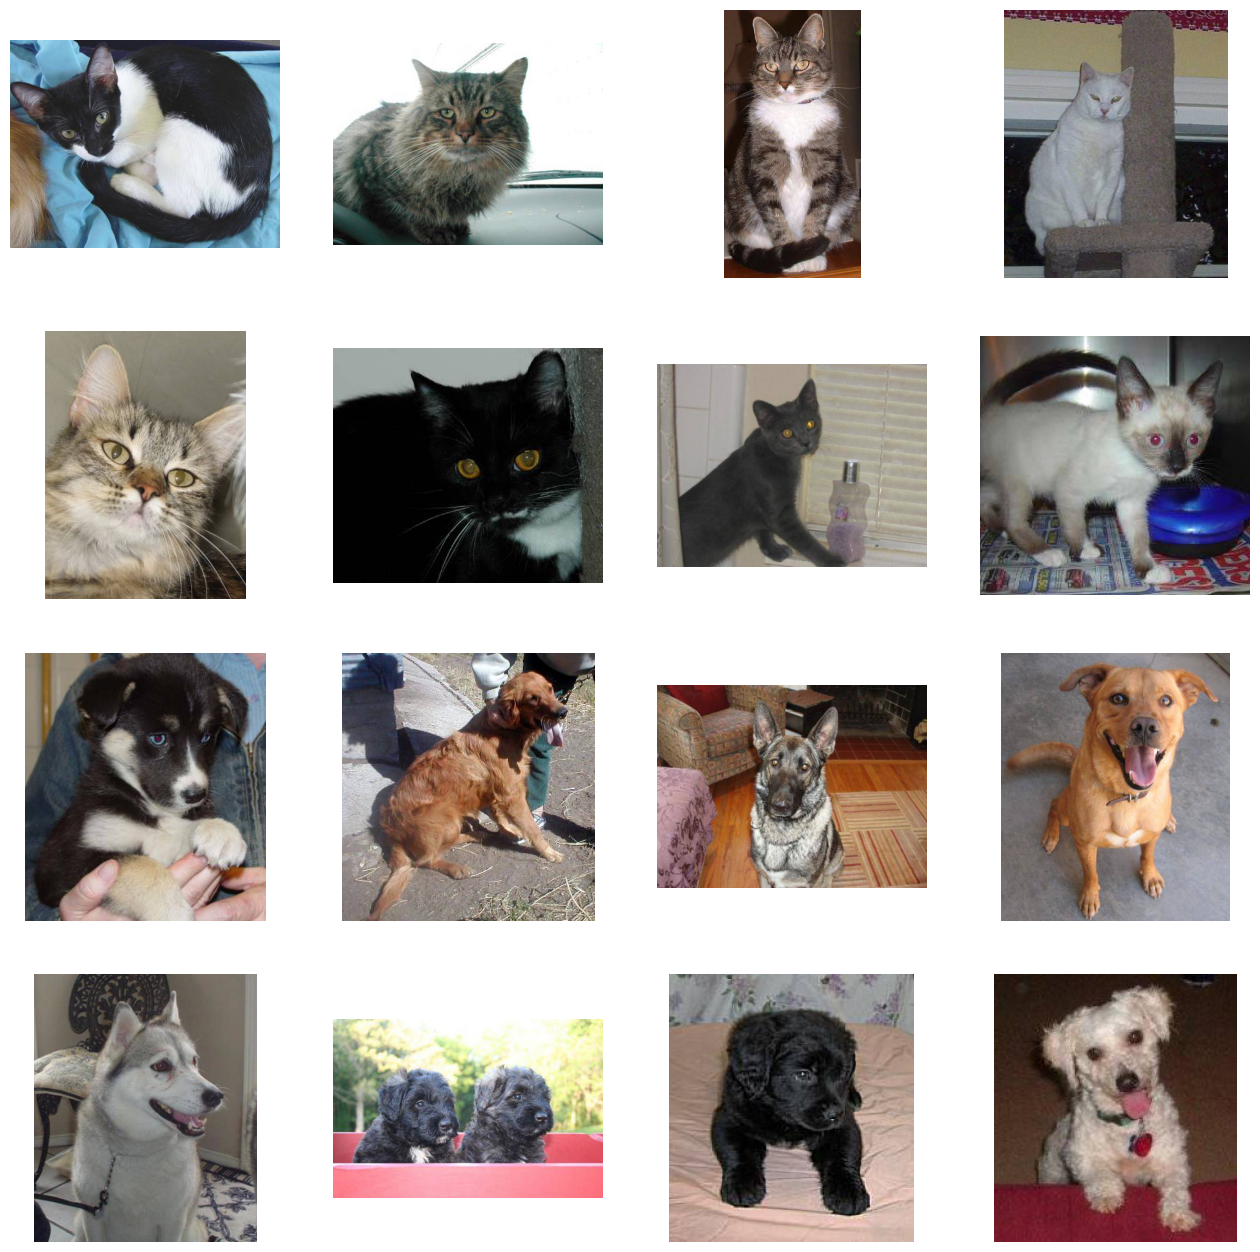

In [9]:

# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Image Augmentation 

In [18]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [20]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))


Found 2000 images belonging to 2 classes.


In [21]:
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))


Found 1000 images belonging to 2 classes.


In [22]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

2023-03-15 12:20:27.685191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 12:20:27.685273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-15 12:20:27.685315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-15 12:20:27.685357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-15 12:20:27.719285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

58900480/58889256 [==============================] - 6s 0us/step


In [24]:
for layer in base_model.layers:
    layer.trainable = False

# fit the model

In [25]:
x = layers.Flatten()(base_model.output)


In [26]:
x

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>

In [27]:
x = layers.Dense(512, activation='relu')(x)


In [28]:
x = layers.Dropout(0.5)(x)


In [29]:
x = layers.Dense(1, activation='sigmoid')(x)


In [30]:
model = tf.keras.models.Model(base_model.input, x)


In [31]:
model

In [33]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])


In [35]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


2023-03-15 12:23:41.860118: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256901120 exceeds 10% of free system memory.
2023-03-15 12:23:41.927107: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256901120 exceeds 10% of free system memory.


  1/100 [..............................] - ETA: 2:16 - loss: 1.3820 - acc: 0.3500

2023-03-15 12:23:42.610693: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256901120 exceeds 10% of free system memory.
2023-03-15 12:23:42.644550: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256901120 exceeds 10% of free system memory.


  2/100 [..............................] - ETA: 1:10 - loss: 3.8610 - acc: 0.4000

2023-03-15 12:23:43.329264: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 256901120 exceeds 10% of free system memory.


100/100 [==============================] - 111s 1s/step - loss: 0.7120 - acc: 0.6720 - val_loss: 0.3672 - val_acc: 0.8150
Epoch 2/10
100/100 [==============================] - 106s 1s/step - loss: 0.4766 - acc: 0.7775 - val_loss: 0.2566 - val_acc: 0.8930
Epoch 3/10
100/100 [==============================] - 107s 1s/step - loss: 0.4313 - acc: 0.7940 - val_loss: 0.2979 - val_acc: 0.8650
Epoch 4/10
100/100 [==============================] - 107s 1s/step - loss: 0.3867 - acc: 0.8310 - val_loss: 0.2521 - val_acc: 0.8910
Epoch 5/10
100/100 [==============================] - 106s 1s/step - loss: 0.3617 - acc: 0.8405 - val_loss: 0.3323 - val_acc: 0.8500
Epoch 6/10
100/100 [==============================] - 107s 1s/step - loss: 0.3557 - acc: 0.8495 - val_loss: 0.2125 - val_acc: 0.9160
Epoch 7/10
100/100 [==============================] - 107s 1s/step - loss: 0.3607 - acc: 0.8380 - val_loss: 0.1850 - val_acc: 0.9190
Epoch 8/10
100/100 [==============================] - 108s 1s/step - loss: 0.332

In [37]:
print("The Accuracy is:",0.9280)

The Accuracy is: 0.928
